In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import ensemble,svm,tree,neighbors,neural_network
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from pandas.api.types import is_numeric_dtype
from sklearn.metrics import mean_squared_error
np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data_train = pd.read_csv('gdrive/My Drive/train.csv')
data_test = pd.read_csv('gdrive/My Drive/test.csv')

In [0]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30143 entries, 0 to 30142
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CAL     30143 non-null  float64
 1   CNC     30143 non-null  float64
 2   GR      30143 non-null  float64
 3   HRD     30143 non-null  float64
 4   HRM     30143 non-null  float64
 5   PE      30143 non-null  float64
 6   ZDEN    30143 non-null  float64
 7   DTC     30143 non-null  float64
 8   DTS     30143 non-null  float64
dtypes: float64(9)
memory usage: 2.1 MB


In [0]:
data_train = data_train.replace(-999.000000, np.NaN)
data_train = data_train.dropna(axis=0)
data_train = data_train[data_train.PE>0]
data_train = data_train[(data_train.CNC>0) & (data_train.CNC<1)]
data_train = data_train[(data_train.GR>0) & (data_train.GR<=200)]
data_train = data_train[(data_train.HRM>0) & (data_train.HRM<1000)]

In [0]:
# from pandas.api.types import is_numeric_dtype
# np.random.seed(42)
# def remove_outlier(data):
#     for name in data.columns:
#         if is_numeric_dtype(data[name]):
#             Q1=data[name].quantile(0.25)
#             Q3=data[name].quantile(0.75)
#             IQR=Q3-Q1
#             low =Q1-1.5*IQR
#             high =Q3+1.5*IQR
#             data = data[(data[name] > low) & (data[name] < high)]
#     return data
# data_train = remove_outlier(data_train)
# data_test = remove_outlier(data_test)

In [0]:
data_train.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN,DTC,DTS
count,19914.000000,19914.000000,19914.000000,19914.000000,19914.000000,19914.000000,19914.000000,19914.000000,19914.000000
mean,8.420684,0.234634,43.041783,2.549664,2.729369,3.918066,2.415154,87.690775,181.326134
std,1.866603,0.158159,33.503649,3.149095,9.576053,4.384227,0.181935,23.589953,85.581774
min,5.930400,0.014500,1.038900,0.129500,0.185300,0.002500,0.680600,49.970500,80.580400
25%,6.604500,0.118525,15.333725,0.791975,0.784475,0.050400,2.236700,70.151150,126.657675
50%,8.578100,0.182750,36.523400,1.738500,1.744950,3.835050,2.474400,78.738800,141.425650
75%,8.671900,0.308250,59.410400,3.211350,3.356500,7.107000,2.565500,99.600500,190.416275
max,21.064200,0.998600,199.675600,124.249400,914.191200,28.106400,3.259700,155.980300,487.438400


In [0]:
data_test.describe()

,CAL,CNC,GR,HRD,HRM,PE,ZDEN
count,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000,11088.000000
mean,8.634049,0.158501,28.966414,4.028372,106.752210,7.353522,2.475884
std,0.044064,0.091298,43.648163,7.198112,2374.620246,1.239075,0.149440
min,8.500000,0.009800,0.852000,0.083900,0.102700,4.760800,2.033400
25%,8.625000,0.091700,8.449450,1.760775,1.865575,6.528075,2.378175
50%,8.625000,0.128300,18.168650,2.758900,3.176950,7.881700,2.533600
75%,8.671900,0.213500,36.470725,4.539675,5.034600,8.308325,2.581800
max,8.875000,0.559400,1124.442000,202.233000,62290.769500,13.840700,3.024800


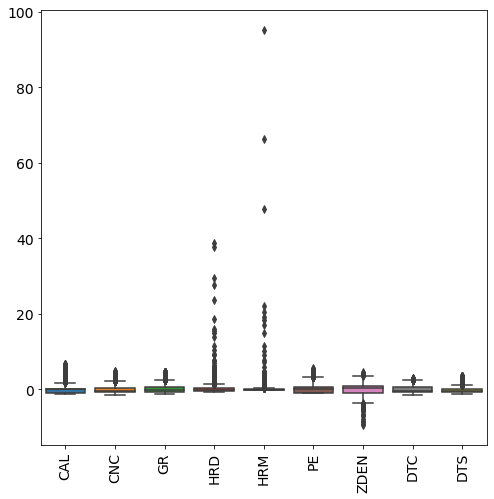

In [0]:
data_normalized = (data_train - data_train.mean())/data_train.std()
plt.figure(figsize=(8,8))
sns.boxplot(data=data_normalized)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('boxplot_pdda.png',bbox_inches="tight",quality=95,dpi=600)
from google.colab import files
files.download('boxplot_pdda.png')


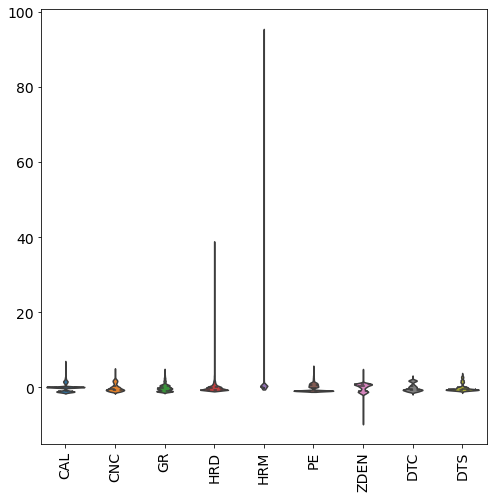

In [0]:
plt.figure(figsize=(8,8))
sns.violinplot(data=data_normalized,split=True, inner="quart")
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.savefig('violin_pdda.png',bbox_inches="tight",quality=95,dpi=600)
from google.colab import files
files.download('violin_pdda.png')

In [0]:
def corr(x, y, **kwargs):
    coef = np.corrcoef(x, y)[0][1]
    label = r'$\rho$ = ' + str(round(coef, 2))
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
grid=sns.pairplot(data_train,kind='reg',diag_kind="kde",markers="o",
             diag_kws=dict(shade=True))
grid.map_upper(corr)
grid.map_lower(corr)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

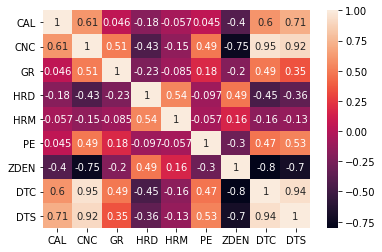

In [0]:
sns.heatmap(data_train.corr(), annot=True)
plt.savefig('heatmap_pdda.png',bbox_inches="tight",quality=95,dpi=600)
from google.colab import files
files.download('heatmap_pdda.png')

In [0]:
scaler=preprocessing.StandardScaler()
data_train = data_train.to_numpy()
y = data_train[:,-2:]
x = data_train[:,:-2]
x=scaler.fit_transform(x)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [0]:
import warnings
warnings.filterwarnings("ignore")

estimator = MultiOutputRegressor(xgboost.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
))

parameters = {
    'estimator__max_depth':[10,12,15],
    'estimator__n_estimators': [50,100],
    'estimator__learning_rate': [0.05,0.1],
    'estimator__min_child_weight': [1,3,5,7],
    'estimator__gamma': [0.1,0.2,0.3],
    'estimator__colsample_bytree':[0.8,0.9],
    'estimator__subsample':[0.8,0.9]
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'r2',
    cv = 5,
    verbose=True
)

gs.fit(x_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed: 173.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MultiOutputRegressor(estimator=XGBRegressor(base_score=0.5,
                                                                   booster='gbtree',
                                                                   colsample_bylevel=1,
                                                                   colsample_bynode=1,
                                                                   colsample_bytree=1,
                                                                   gamma=0,
                                                                   importance_type='gain',
                                                                   learning_rate=0.1,
                                                                   max_delta_step=0,
                                                                   max_depth=3,
                                                                   min_child_weight=1,
                             

In [0]:
y_pred_train=gs.predict(x_train)
y_pred_test=gs.predict(x_test)
print('DTC Result')
print(r2_score(y_train[:,0],y_pred_train[:,0]))
print(r2_score(y_test[:,0],y_pred_test[:,0]))
rmse_test_dtc = np.sqrt(mean_squared_error(y_test[:,0], y_pred_test[:,0]))
rmse_train_dtc = np.sqrt(mean_squared_error(y_train[:,0], y_pred_train[:,0]))
print("Root Mean Squared Error of Training Set: {}".format(rmse_train_dtc))
print("Root Mean Squared Error of Testing Set: {}".format(rmse_test_dtc))
print('DTS Result')
print(r2_score(y_train[:,1],y_pred_train[:,1]))
print(r2_score(y_test[:,1],y_pred_test[:,1]))
rmse_test_dts = np.sqrt(mean_squared_error(y_test[:,1], y_pred_test[:,1]))
rmse_train_dts = np.sqrt(mean_squared_error(y_train[:,1], y_pred_train[:,1]))
print("Root Mean Squared Error of Training Set: {}".format(rmse_train_dts))
print("Root Mean Squared Error of Testing Set: {}".format(rmse_test_dts))

DTC Result
0.99904495711231
0.9875370786692491
Root Mean Squared Error of Training Set: 0.7288893737410413
Root Mean Squared Error of Testing Set: 2.6348766517451465
DTS Result
0.9995458488272524
0.9910201920180631
Root Mean Squared Error of Training Set: 1.820038472606744
Root Mean Squared Error of Testing Set: 8.175701278757257


findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Tahoma'] not found. Falling back to DejaVu Sans.


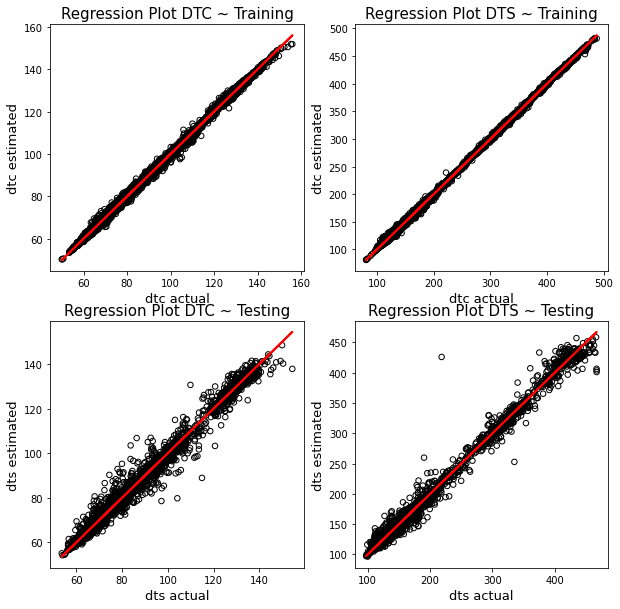

In [0]:
csfont = {'fontname':'Tahoma'}
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,10),nrows=2, ncols=2, sharex=False, sharey=False)
ax1.scatter(y_train[:,0], y_pred_train[:,0], s=30,facecolors='none',edgecolors='black')
ax1.plot(y_train[:,0], y_train[:,0], color='r', linewidth=2)
ax1.set_title("Regression Plot DTC ~ Training",**csfont, fontsize=15)
ax1.set_xlabel('dtc actual', **csfont, fontsize=13)
ax1.set_ylabel('dtc estimated', **csfont, fontsize=13)
ax2.scatter(y_train[:,1], y_pred_train[:,1], s=30,facecolors='none',edgecolors='black')
ax2.plot(y_train[:,1], y_train[:,1], color='r', linewidth=2)
ax2.set_title("Regression Plot DTS ~ Training", **csfont, fontsize=15)
ax2.set_xlabel('dtc actual', **csfont, fontsize=13)
ax2.set_ylabel('dtc estimated', **csfont, fontsize=13)
ax3.scatter(y_test[:,0], y_pred_test[:,0], s=30,facecolors='none',edgecolors='black')
ax3.plot(y_test[:,0], y_test[:,0], color='r', linewidth=2)
ax3.set_title('Regression Plot DTC ~ Testing', **csfont, fontsize=15)
ax3.set_xlabel('dts actual', **csfont, fontsize=13)
ax3.set_ylabel('dts estimated', **csfont, fontsize=13)
ax4.scatter(y_test[:,1], y_pred_test[:,1], s=30,facecolors='none',edgecolors='black')
ax4.plot(y_test[:,1], y_test[:,1], color='r', linewidth=2)
ax4.set_title('Regression Plot DTS ~ Testing', **csfont, fontsize=15)
ax4.set_xlabel('dts actual', **csfont, fontsize=13)
ax4.set_ylabel('dts estimated', **csfont, fontsize=13)
plt.savefig('reg_line.png',bbox_inches="tight",quality=95,dpi=600)
from google.colab import files
files.download('reg_line.png')

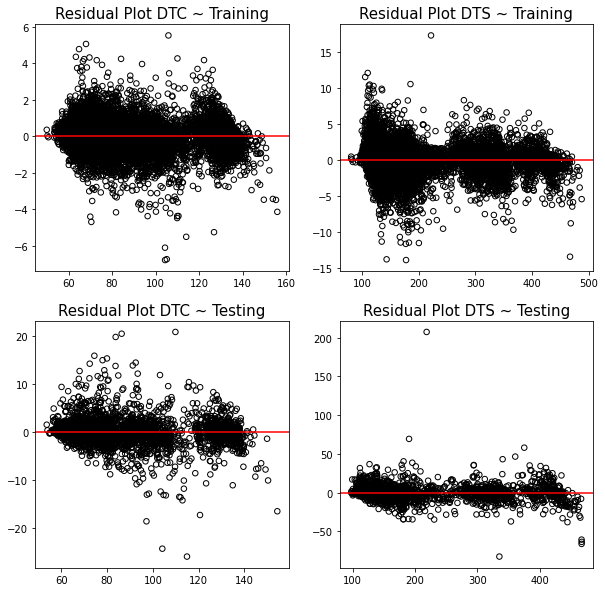

In [0]:
resid_train_dtc = y_pred_train[:,0] - y_train[:,0]
resid_train_dts = y_pred_train[:,1] - y_train[:,1]
resid_test_dtc = y_pred_test[:,0] - y_test[:,0]
resid_test_dts = y_pred_test[:,1] - y_test[:,1]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(10,10),nrows=2, ncols=2, sharex=False, sharey=False)
ax1.scatter(y_train[:,0], resid_train_dtc, s=30,facecolors='none',edgecolors='black')
ax1.axhline(y=0, color='r', linestyle='-')
ax1.set_title("Residual Plot DTC ~ Training", fontsize=15)
ax2.scatter(y_train[:,1], resid_train_dts, s=30,facecolors='none',edgecolors='black')
ax2.axhline(y=0, color='r', linestyle='-')
ax2.set_title("Residual Plot DTS ~ Training", fontsize=15)
ax3.scatter(y_test[:,0], resid_test_dtc, s=30,facecolors='none',edgecolors='black')
ax3.axhline(y=0, color='r', linestyle='-')
ax3.set_title('Residual Plot DTC ~ Testing', fontsize=15)
ax4.scatter(y_test[:,1], resid_test_dts, s=30,facecolors='none',edgecolors='black')
ax4.axhline(y=0, color='r', linestyle='-')
ax4.set_title('Residual Plot DTS ~ Testing', fontsize=15)
plt.savefig('residuals.png',bbox_inches="tight",quality=95,dpi=600)
from google.colab import files
files.download('residuals.png')

In [0]:
data_test = pd.read_csv('gdrive/My Drive/test.csv')
data_test_array = data_test.to_numpy()
data_test_array = scaler.fit_transform(data_test_array)
data_test_results = gs.predict(data_test_array)
data_test[['DTC', 'DTS']] = pd.DataFrame({'DTC': data_test_results[:, 0], 'DTS': data_test_results[:, 1]})
data_test.to_excel('output.xlsx', index=False)

In [0]:
from google.colab import files
files.download('output.xlsx')